In [1]:
import os
import sys
os.environ['OMP_NUM_THREADS'] = '1'
os.environ["THEANO_FLAGS"] = "device=gpu"
sys.path.append(os.getcwd()+"/..")
import lasagne
import theano.tensor as T
import theano
from tasks import check
from scripts import manifold
from lasagne import layers as L

from lasagnekit.misc.plot_weights import dispims_color, tile_raster_images
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.io import imsave

from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import TSNE
from image_scatter import image_scatter
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
from lasagnekit.misc.plot_weights import tile_raster_images
import numpy as np

from helpers import salt_and_pepper
def sample(x):
    return (np.random.uniform(size=x.shape) <= x).astype(np.float32)


def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, max(len(inputs) - batchsize + 1, len(inputs)), batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: Tesla K20Xm (CNMeM is disabled, cuDNN Mixed dnn version. The header is from one version, but we link with a different version (5005, 3007))


## load model

In [26]:
v = check(
    what="notebook", 
    filename="../training/fonts/dense3/model.pkl",
    force_w=28,
    force_h=28,
    dataset="fonts"
)

Loading data...


INFO:tasks:Loading data...


Loading the model...


INFO:tasks:Loading the model...


(None, 1, 28, 28)
Compiling the model...


INFO:tasks:Compiling the model...


{'patience_stat': 'loss_train', 'epsilon': 1e-08, 'max_nb_epochs': 2000, 'batch_size': 128, 'initial_lr': 0.1, 'patience_nb_epochs': 20, 'lr_decay_method': 'none', 'beta2': 0.95, 'beta1': 0.95, 'min_nb_epochs': 213, 'lr_decay': 0, 'momentum': 0.9, 'algo': u'adadelta'}
{'seed': 2}


In [27]:
capsule, data, layers, w, h, c = v

In [28]:
X = T.tensor4()
encode = theano.function([X], L.get_output(layers['hid2'], X))

## viz features

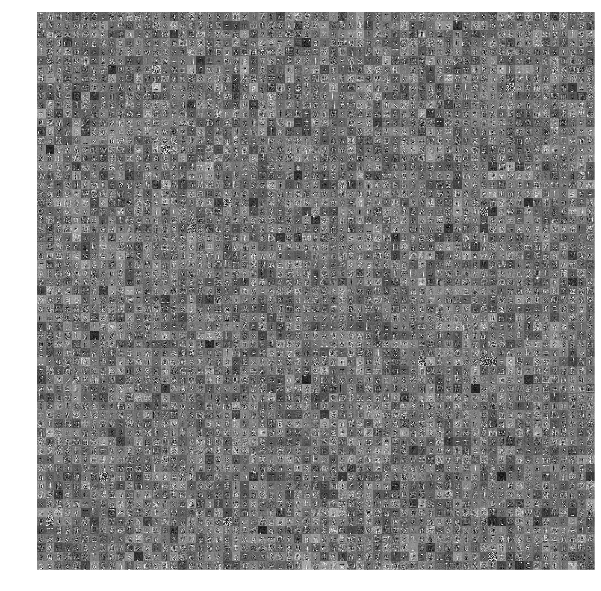

ValueError: total size of new array must be unchanged

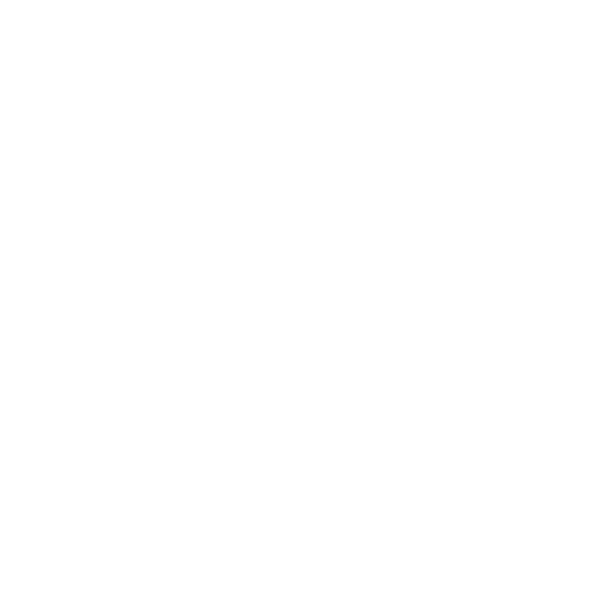

In [5]:
for name, layer in layers.items():
    if hasattr(layer, "W"):
        W = layer.W.get_value()
        if len(W.shape)==2:
            nbpixels = c*w*h
            if W.shape[0] == nbpixels:
                W = W.T
            a, b = w, h
        else:
            W = W.reshape((W.shape[0]*W.shape[1], W.shape[2], W.shape[3]))
            a, b = W.shape[1:]
        fig = plt.figure(figsize=(10, 10))
        s = int(np.sqrt(W.shape[0]))
        plt.axis('off')
        img=tile_raster_images(W, (a, b), (s, s))
        plt.imshow(img, cmap="gray", interpolation='none')
        plt.show()

## iterative refinement

In [35]:
seed = 42
np.random.seed(seed)
N = 100
s = np.random.uniform(0, 1, size=(N, c, w, h))
s = s.astype(np.float32)
samples = []
samples.append(s.copy()[None, :, :, :, :])
nb_iter = 60
loss = []
for i in tqdm(range(nb_iter)):
    sprev = s  
    #s = s > 0.6
    s = s + 0.01*(capsule.reconstruct(s) - s)
    s = s.astype(np.float32)
    samples.append(s.copy()[None, :, :, :, :])
    #s = np.random.binomial(n=1, p=s, size=s.shape).astype('float32')# binarize by sampling
    #s = s > 0.6
    score = np.abs(s - sprev).sum()
    loss.append(score)
samples = np.concatenate(samples, axis=0)
print(samples.shape)
print(loss)

(61, 100, 1, 28, 28)
[317.43008, 316.38626, 315.19037, 313.83594, 312.32593, 310.68835, 308.92755, 307.04669, 305.05347, 302.96313, 300.78891, 298.53177, 296.20105, 293.80865, 291.36334, 288.87476, 286.34787, 283.79318, 281.20081, 278.58243, 275.94818, 273.29874, 270.64319, 267.97549, 265.30295, 262.63257, 259.96912, 257.31122, 254.66342, 252.02821, 249.41003, 246.80759, 244.22377, 241.65924, 239.11606, 236.59404, 234.09491, 231.6189, 229.16473, 226.73264, 224.32523, 221.94304, 219.58484, 217.25017, 214.93991, 212.6539, 210.39165, 208.15213, 205.93512, 203.74115, 201.57063, 199.42319, 197.29846, 195.19624, 193.11615, 191.05785, 189.02156, 187.00732, 185.01543, 183.04582]


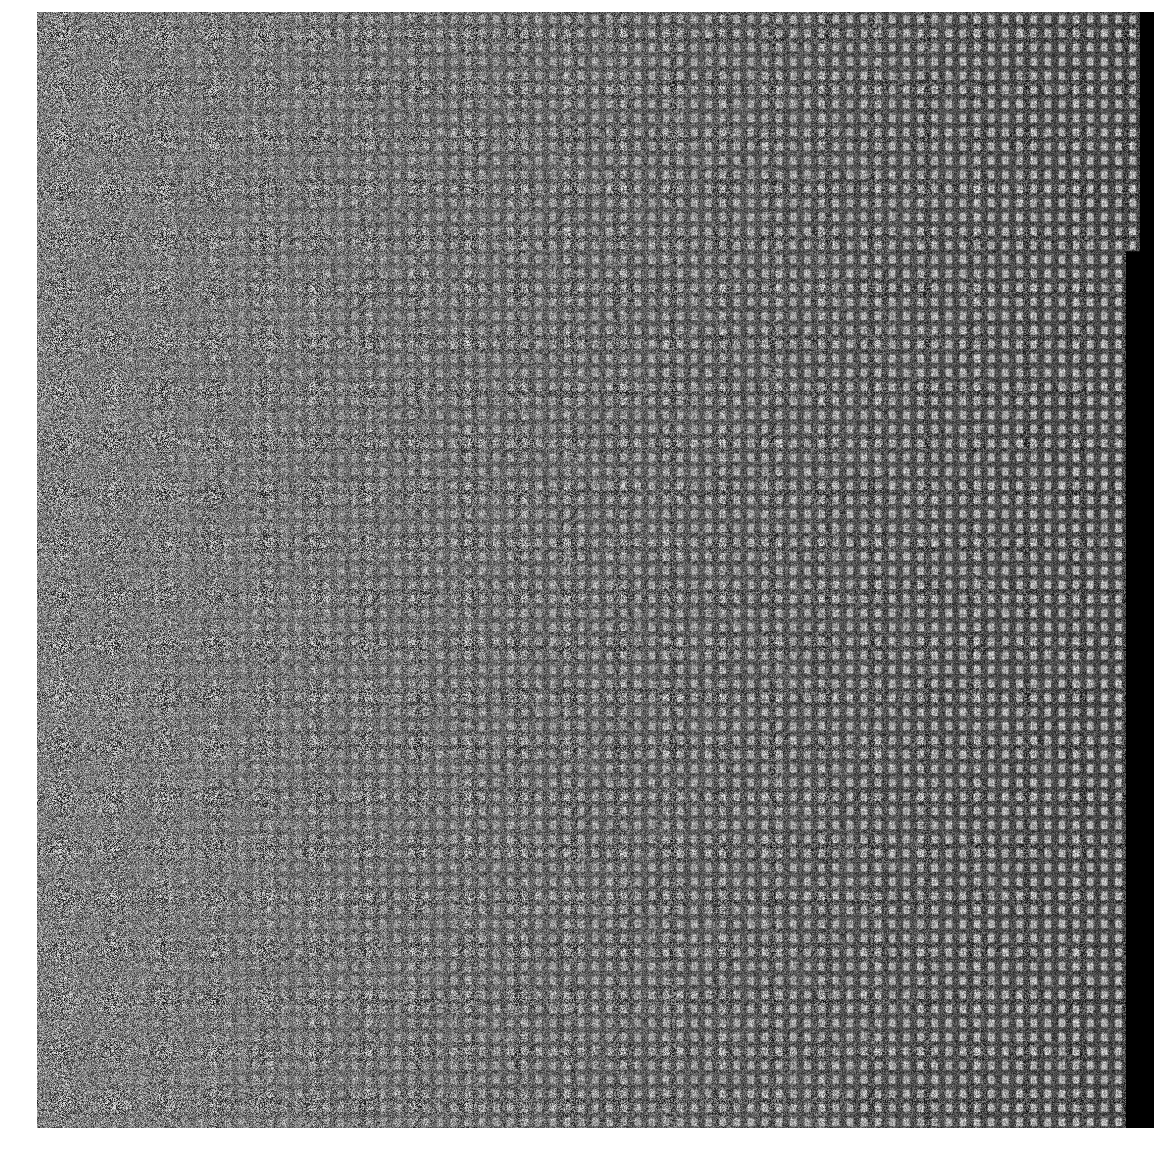

In [36]:
fig = plt.figure(figsize=(20, 20))
sw, sh = samples.shape[0:2]
samples_ = samples.copy()
samples_ = samples_.reshape((sw*sh, c, w, h))
samples_ = samples_.transpose((0, 2, 3, 1))
samples_ = samples_ * np.ones((1, 1, 1, 3))
img = dispims_color(samples_)
imsave('out.png', img)
plt.imshow(img)
plt.axis('off')
plt.show()

In [22]:
h = []
d = []
for i in range(10):
    d.append(capsule.preprocess(data.X).transpose((0, 2 ,3 , 1))  * np.ones((1, 1, 1, 3)))
    h.append(encode(capsule.preprocess(data.X)))

d = np.concatenate(d, axis=0)
h = np.concatenate(h, axis=0)

In [11]:
#mf = IncrementalPCA(n_components=2, batch_size=1024)
mf = PCA(n_components=2)
#mf = TSNE(n_components=2, verbose=1)
h2d = mf.fit_transform(h)

In [12]:
mf = PCA(n_components=2)
#mf = IncrementalPCA(n_components=2, batch_size=1024)
#mf = TSNE(n_components=2, verbose=1)
d2d = mf.fit_transform(d.reshape(d.shape[0], -1))

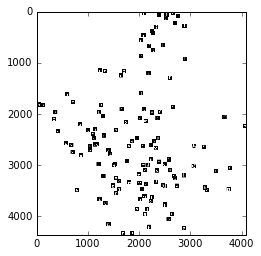

In [14]:
img = image_scatter(h2d, d, 80)
imsave('out_scatter.png', img)
plt.imshow(img, cmap='gray')
plt.show()

In [16]:
img = image_scatter(d2d, d, 80)
imsave('out_scatter_data.png', img)
plt.imshow(img, cmap='gray')
plt.show()

KeyboardInterrupt: 

## transferability

In [ ]:
from lasagnekit.datasets.mnist import MNIST

In [ ]:
mnist = MNIST()
mnist.load()
X_transf_orig = mnist.X.reshape((mnist.X.shape[0], c, w, h))
X_transf_orig = X_transf_orig[mnist.y==5]
X_transf_orig = X_transf_orig[0:500]

In [ ]:
X_transf_rec = X_transf_orig.copy().astype(np.float32)
X_transf_rec = X_transf_rec
for i in range(1):
    X_transf_rec = capsule.reconstruct(X_transf_rec)
    print(((X_transf_rec - capsule.reconstruct(X_transf_rec))**2).sum(axis=(1, 2, 3)).mean())

In [ ]:
X_transf = X_transf_orig.transpose((0, 2, 3, 1))
X_transf = X_transf * np.ones((1, 1, 1, 3))

X_transf_rec = X_transf_rec.transpose((0, 2, 3, 1))
X_transf_rec = X_transf_rec * np.ones((1, 1, 1, 3))

In [ ]:
fig = plt.figure(figsize=(20, 20))
img = dispims_color(X_transf_rec[0:500])
plt.imshow(img, cmap='gray')
plt.show()
fig = plt.figure(figsize=(20, 20))
img = dispims_color(X_transf[0:500])
plt.imshow(img, cmap='gray')
plt.show()